# Biomedical Imaging 4C16/5C16 Project

## Tumor Segmentation & Classification

#### About the dataset

You have been given a dataset of ultrasound scans and segmentation maps associated with these ultrasound scans. These scans are to be used for training networks for ***breast cancer tumor segmentation and classification***.

The dataset has already been prepared to numpy files and is in the 'dataset' directory and is of the following structure:

- *dataset/*
    - *benign/*
        - *input.npy*
        - *target.npy*
    - *malignant/*
        - *input.npy*
        - *target.npy*
    - *normal/*
        - *input.npy*
        - *target.npy*

The *input.npy* and *output.npy* files are the input ultrasound scans and target segmentation maps for that tumor category (benign, malignant, normal).

- All input ultrasound scans are images of size 128x128x3. This means the height and width of these images are 128 and it is stored in RGB space. The pixels range from 0-1.
- All segmentation maps are images of size 128x128x1. This is an image where a value of 1 means that a tumor is detected at that location, and 0 means there is no tumor present.

The code block below displays examples of ultrasound scans and tumor segmentation maps for these image pairs.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-06


In [ ]:
# Function to save a model
def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print("Saved model to model.json and weights to model.h5")

In [ ]:
# Download the dataset
!curl --create-dirs -o /home/tcd/data/medicalimaging-dataset.zip https://tcddeeplearning.blob.core.windows.net/deeplearning202324/medicalimaging-dataset.zip

!mkdir -p /home/tcd/data/medicalimaging/
!unzip -o /home/tcd/data/medicalimaging-dataset.zip -d /home/tcd/data/medicalimaging/

# Dataset is located in /home/tcd/data/medicalimaging/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.1M  100 16.1M    0     0  27.6M      0 --:--:-- --:--:-- --:--:-- 27.6M
Archive:  /home/tcd/data/medicalimaging-dataset.zip
  inflating: /home/tcd/data/medicalimaging/dataset/normal/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/normal/target.npy  


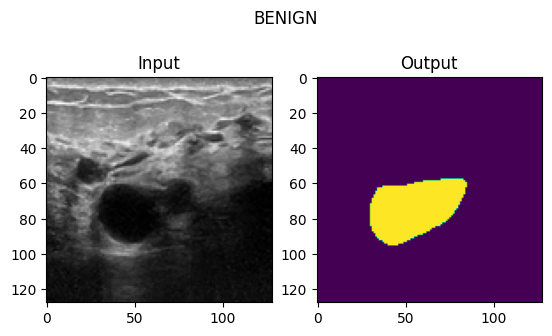

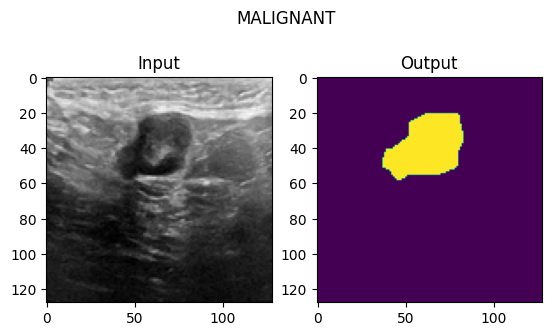

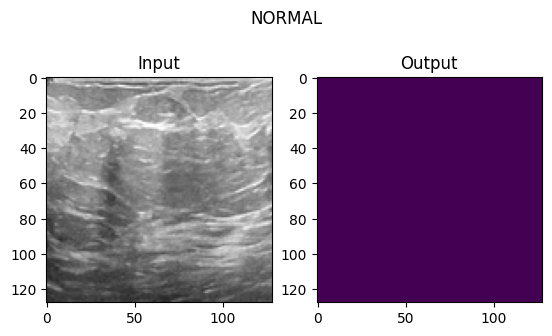

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

for _type in ['benign', 'malignant', 'normal']:
    X = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/input.npy')
    y = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/target.npy')
    randomExample = random.randint(0, X.shape[0] - 1)
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(X[randomExample])
    axs[0].title.set_text('Input')
    axs[1].imshow(y[randomExample])
    axs[1].title.set_text('Output')
    fig.suptitle(_type.upper())
    plt.subplots_adjust(top=1.1)
    plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from tensorflow.keras import layers
from IPython.display import clear_output
import scipy as scp
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow import keras

In [ ]:
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();



In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
#from tensorflow.keras.applications.efficientnet import EfficientNetBO

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [ ]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical

def get_label_index(label):

    label_dict = {'benign': 0, 'malignant': 1, 'normal': 2}
    return label_dict[label]

def load_set(set_path, label):
    data_inputs = np.load(f"{set_path}/{label}/input.npy")
    label_index = get_label_index(label)
    num_samples = data_inputs.shape[0]
    label_indices = np.empty(num_samples, dtype=int)
    for i in range(num_samples):
      label_indices[i] = label_index

    return data_inputs, label_indices

path = "/home/tcd/data/medicalimaging/dataset"
t_type = ['benign', 'malignant', 'normal']

In [ ]:
import numpy as np
import scipy.ndimage as sp_imaging
import tensorflow as tf
from scipy.ndimage import shift

def shear_transform(matrix, shear_factor, axes):
    affine_transform = np.eye(len(matrix.shape))
    affine_transform[axes[0], axes[1]] = shear_factor
    return sp_imaging.affine_transform(matrix, affine_transform)




def augment(X, y):

    rotated = sp_imaging.rotate(X, angle=75, axes=(1, 2), reshape=False)

    enhanced_contrast = tf.image.adjust_contrast(X, 1.5)

    #Blurred image
    blurred = sp_imaging.gaussian_filter(X, sigma=0.4)

    flipped = np.fliplr(X)


    #shifted = shift(X, shift=[5, 0, 0])
    #shear transform
    sheared = shear_transform(X, shear_factor=0.5, axes=(1, 2))

    # Convert lists to numpy arrays
    augmented_images = np.concatenate([X, enhanced_contrast, blurred, rotated, sheared, flipped])
    augmented_labels = np.concatenate([y] * 6)

    return augmented_images, augmented_labels




In [ ]:
import scipy.ndimage as sp_imaging
import numpy as np
path = "/home/tcd/data/medicalimaging/dataset"
category = t_type
# Initialize lists to store all images and labels
all_images_data = [load_set(path, type_) for type_ in category]
imgs, labels = zip(*all_images_data)
augmented_images, augmented_labels = augment(
    np.vstack(imgs), np.concatenate(labels)
)




In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(augmented_images, augmented_labels, test_size=0.3, random_state=42)


In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers


base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet', alpha=0.35)
base_model.trainable = False


inputs = layers.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation='softmax')(x)

classification_model = models.Model(inputs, outputs)




In [ ]:
if classification_model.count_params() < 5000000:
  print('currebtly params = ',classification_model.count_params())
else:
  print("reduce params")
  print('currebtly params = ',classification_model.count_params())

currebtly params =  1725027


In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#model_checkpoint = callbacks.ModelCheckpoint('classification_model.h5', save_best_only=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100000,
    decay_rate=0.3,
    staircase=True)
optimizer = optimizers.Adam(learning_rate=lr_schedule)

classification_model.compile(optimizer=optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
pltCallBack = PlotLossAccuracy()
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=5, verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
     pltCallBack,
]

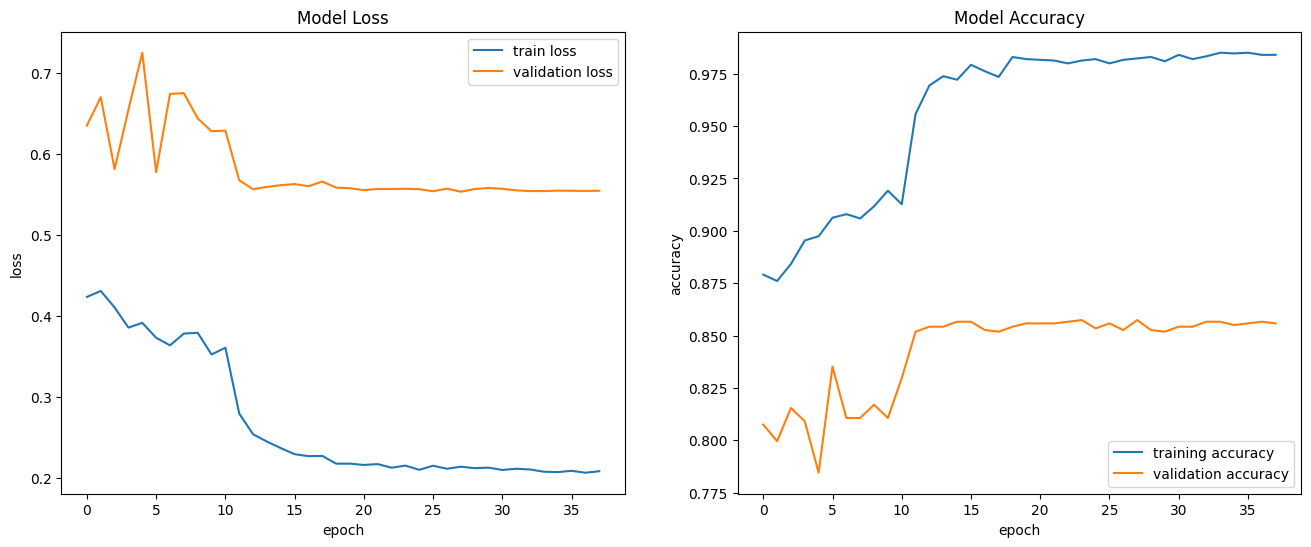

99/99 [==============================] - 3s 30ms/step - loss: 0.2082 - accuracy: 0.9840 - val_loss: 0.5545 - val_accuracy: 0.8558 - lr: 1.0000e-06
Epoch 38: early stopping


In [ ]:
from tensorflow.keras import callbacks

# Define callbacks
#lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
# lr_rate_red = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
# early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10)



# Train the model
classification_model.fit(
    X_train, Y_train,
    batch_size=30,
    epochs=60,
    validation_data=(X_test, Y_test),
    callbacks = callbacks_list
)


In [ ]:
#classification_model = model
if (classification_model.count_params()  < 5000000) :
  save_model_to_disk(classification_model, "classification_model")
else:
  print("Your model is unecessarily complex, scale down!")

Saved model to model.json and weights to model.h5


### The problem

You are required to train two separate neural networks for the purposes of:

1. **Classification Task**: Predicting whether an ultrasound is a) benign tumor,  b) contains a malignant tumor or c) normal (no-tumor).
    - Input are ultra sound scans (data from benign/malignant/normal), the output is a vector of the 3 probabilities for the classes (benign/malignant/normal) in that order (eg. [0.01, 0.99, 0] means the outcome is more likely to be malignant).
2. **Segmentation Task**: Predicting the segmentation map for a tumor of an input MRI scan if a tumor exists
    - Input are ultra sound scans (data from benign/malignant/normal), output is an image with the same height and width as the input image, but with only one channel and a value of 1 over the location where a tumor is present.

---

*IMPORTANT*

For Task 1, your model should be created with the name: 'classification_model',
the model size should be under 5M

For Task 2, your model should be created with the name: 'segmentation_model',
the model size should be under 3M.

In [ ]:
# Hints:
#
# Load data into appropriate input/output formats.
# For example, for problem 1:
#   * inputs should be a collection of images of size [n_samples x height x width x 3],
#   * outputs should be of size [n_samples x height x width x 1].
#
# Load images using the `np.load` function. You can combine tensors using `np.concat`
# to form a single input or output dataset tensor. Look at previous labs for inspiration
# on what datasets look like.
#
# The amount of training data is very low, so usage of data
# augmentation techniques is strongly advised.(eg. see tf.keras.layers.RandomRotation)
#
# Classification Task hint: you may also think of using pre-trained networks
# with fine-tuning.
# Keep the model size under the restriction of 5Million parameters, you should
# be able to hit the target at much less model size. (Lower the better:))
#
# Segmentation Task hint: You might want to use transpose convolution layers to go up in tensor size.
# Popular segmentation architectures include U-Net (with skip-connections) or DnCNN.
# Keep the model size under the restriction of 3 Million parameters, you should
# be able to hit the target at very much lower model size. (Lower the better:))

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

DATASET_PATH = "/home/tcd/data/medicalimaging/dataset"

def fetch_dataset(dataset_path):
    inputs, labels = [], []

    inputs_benign = np.load(f'{dataset_path}/benign/input.npy')
    labels_benign = np.load(f'{dataset_path}/benign/target.npy')
    inputs_malignant = np.load(f'{dataset_path}/malignant/input.npy')
    labels_malignant = np.load(f'{dataset_path}/malignant/target.npy')
    inputs_normal = np.load(f'{dataset_path}/normal/input.npy')
    labels_normal = np.load(f'{dataset_path}/normal/target.npy')
    inputs.append(inputs_benign)
    inputs.append(inputs_malignant)
    inputs.append(inputs_normal)
    labels.append(labels_benign)
    labels.append(labels_malignant)
    labels.append(labels_normal)

    inputs = np.concatenate(inputs, axis=0)
    labels = np.concatenate(labels, axis=0)
    return inputs, labels

In [ ]:

def encode_block(tensor, filters_count):
    conv = convolution_layer(tensor, filters_count)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool


In [ ]:
def decode_block(tensor, tensor_concat, filters_count):
    upsample = UpSampling2D((2, 2))(tensor)
    merge = Concatenate()([upsample, tensor_concat])
    conv = convolution_layer(merge, filters_count)
    return conv

def build_model(shape_input):
    input_layer = Input(shape_input)

    conv1, pool1 = encode_block(input_layer, 32)
    conv2, pool2 = encode_block(pool1, 64)
    conv3, pool3 = encode_block(pool2, 128)
    bridge = convolution_layer(pool3, 256)

    decode1 = decode_block(bridge, conv3, 128)
    decode2 = decode_block(decode1, conv2, 64)
    decode3 = decode_block(decode2, conv1, 32)

    decode4 = Conv2D(3, (3, 3), activation='softmax', padding='same')(decode3)
    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decode4)

    return Model(inputs=[input_layer], outputs=[output_layer])

def convolution_layer(tensor, filters_count):
    conv = Conv2D(filters_count, (3, 3), activation='relu', padding='same')(tensor)
    conv = BatchNormalization()(conv)
    conv = Conv2D(filters_count, (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
    return conv

In [ ]:
def calculate_precision(true_labels, predictions):
    tp = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(true_labels * predictions, 0, 1)))
    predicted_pos = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(predictions, 0, 1)))
    precision_value = tp / (predicted_pos + tf.keras.backend.epsilon())
    return precision_value

def calculate_recall(true_labels, predictions):
    tp = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(true_labels * predictions, 0, 1)))
    possible_pos = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(true_labels, 0, 1)))
    recall_value = tp / (possible_pos + tf.keras.backend.epsilon())
    return recall_value

def calculate_f1(true_labels, predictions):
    prec = calculate_precision(true_labels, predictions)
    rec = calculate_recall(true_labels, predictions)
    return 2 * ((prec * rec) / (prec + rec + tf.keras.backend.epsilon()))

In [ ]:
def data_augmentation(images, masks, batch_sz):
    augmentation_args = dict(rotation_range=360, width_shift_range=0.1, height_shift_range=0.1,
                             shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
    img_data_gen = ImageDataGenerator(**augmentation_args)
    mask_data_gen = ImageDataGenerator(**augmentation_args)
    seed_num = 1
    img_gen = img_data_gen.flow(images, batch_size=batch_sz, seed=seed_num)
    mask_gen = mask_data_gen.flow(masks, batch_size=batch_sz, seed=seed_num)
    return zip(img_gen, mask_gen)

In [ ]:
inputs, labels = fetch_dataset(DATASET_PATH)
inputs_train, inputs_val, labels_train, labels_val = train_test_split(inputs, labels, test_size=0.2, random_state=42)



In [ ]:
neural_model = build_model(inputs_train.shape[1:])
neural_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', calculate_precision, calculate_recall, calculate_f1])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_calculate_f1', mode='max', patience=10, restore_best_weights=True)


Epoch 1/100
17/17 [==============================] - 5s 273ms/step - loss: 0.0895 - accuracy: 0.9636 - calculate_precision: 0.8391 - calculate_recall: 0.7033 - calculate_f1: 0.7585 - val_loss: 0.1619 - val_accuracy: 0.9535 - val_calculate_precision: 0.9230 - val_calculate_recall: 0.5195 - val_calculate_f1: 0.6605
Epoch 2/100
17/17 [==============================] - 6s 347ms/step - loss: 0.1024 - accuracy: 0.9617 - calculate_precision: 0.8174 - calculate_recall: 0.6835 - calculate_f1: 0.7400 - val_loss: 0.1535 - val_accuracy: 0.9553 - val_calculate_precision: 0.7971 - val_calculate_recall: 0.6499 - val_calculate_f1: 0.7132
Epoch 3/100
17/17 [==============================] - 4s 219ms/step - loss: 0.1044 - accuracy: 0.9596 - calculate_precision: 0.8408 - calculate_recall: 0.6510 - calculate_f1: 0.7264 - val_loss: 0.1406 - val_accuracy: 0.9548 - val_calculate_precision: 0.8480 - val_calculate_recall: 0.5866 - val_calculate_f1: 0.6903
Epoch 4/100
17/17 [==============================] - 4s

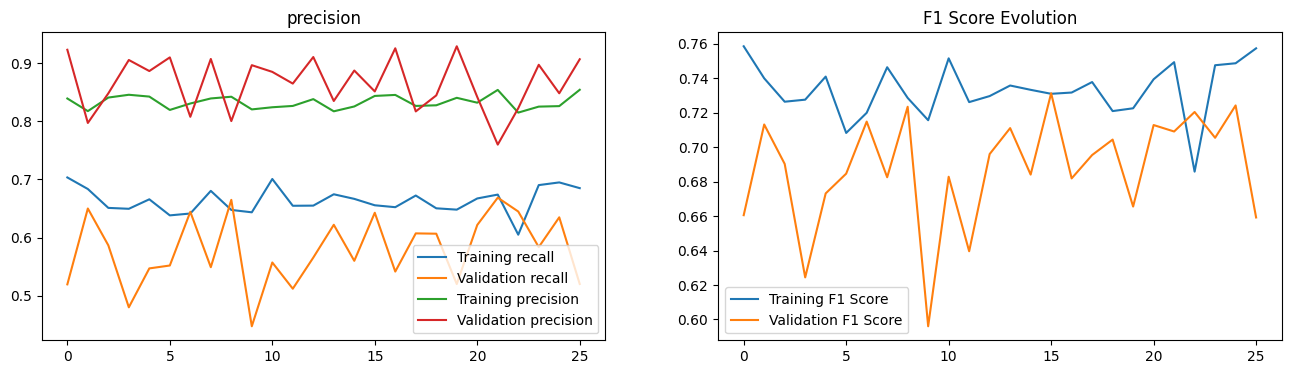

In [ ]:
# Augmenting data
augmented_train = data_augmentation(inputs_train, labels_train, batch_sz=32)

# Model training
training_history = neural_model.fit(augmented_train, steps_per_epoch=len(inputs_train) // 32, epochs=100,
                                    validation_data=(inputs_val, labels_val), callbacks=[early_stopping])

# plt.figure(figsize=(10, 6))

plt.figure(figsize=(16, 4))

# Plot for Training Loss vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(training_history.history['calculate_recall'], label='Training recall')
plt.plot(training_history.history['val_calculate_recall'], label='Validation recall')
plt.title('recall')
plt.legend()

plt.subplot(1, 2, 1)
plt.plot(training_history.history['calculate_precision'], label='Training precision')
plt.plot(training_history.history['val_calculate_precision'], label='Validation precision')
plt.title('precision')
plt.legend()

# Plot for Training F1 Score vs Validation F1 Score
plt.subplot(1, 2, 2)
plt.plot(training_history.history['calculate_f1'], label='Training F1 Score')
plt.plot(training_history.history['val_calculate_f1'], label='Validation F1 Score')
plt.title('F1 Score Evolution')
plt.legend()

plt.show()


In [ ]:
if neural_model.count_params() < 3000000:
  print('currebtly params = ',neural_model.count_params())
else:
  print("reduce params")
  print('currebtly params = ',neural_model.count_params())

currebtly params =  1953375


In [ ]:
segmentation_model = neural_model

if (segmentation_model.count_params()  < 3000000) :
  save_model_to_disk(segmentation_model, "segmentation_model")
else:
  print("Your model is unecessarily complex, scale down!")

Saved model to model.json and weights to model.h5
